# Dataproject

**Table of contents**<a id='toc0_'></a>  
- [1. Objectives](#toc1_)
- [2. Import of packages](#toc2_)
- [3. Reading and cleaning data](#toc3_)
- [4. Merging datasets](#toc4_)
- [5. Analysis](#toc5_)
- [6. Concluding remarks](#toc6_)

## 1. <a id='toc1_'></a>[Objectives](#toc1_)

Focused on exploring the sporting habits of adults in Denmark, this project spans the years 2014-2022, aiming to identify trends in sports participation alongside attendance at sporting events.

Anticipated findings include a positive correlation between membership in sports organizations and attendance at corresponding sporting events. For instance, during the golden era of the Danish national women's handball team in the 1990s, there was a significant surge in memberships within handball organizations across Denmark. As interest in watching games grew, attendance likewise soared in tandem with the increase in memberships.

## 2. <a id='toc2_'></a>[Import of packages](#toc2_)

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will fetch data from DST (Statistikbanken). Being able to do so you need to have the following packages downloaded. Simply remove the `#` if it is not downloaded on your computer.

In [2]:
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install pandas-datareader

Below we download the relevant packages that we will need when cleaning, interacting and plotting our data.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import ipywidgets as widgets
import os 
from dstapi import DstApi
import seaborn as sns

## 3. <a id='toc3_'></a>[Reading and cleaning data](#toc3_)

We will import the data using two different techniques:
1. Downloading and storing data in our repository
2. Fetching directly from DST

Importing the first dataset we exploit technique 1. The data contains information on the number of adult members registered in four of the most popular sport organizations in Denmark. This includes football, handball, basketball and icehockey. 

The data is collected from Danmarks Statistik, DST. 

### **Downloading data**

First of all, we make sure that the data is stored correctly. The data source is https://www.statistikbanken.dk/statbank5a/selectvarval/define.asp?PLanguage=0&subword=tabsel&MainTable=IDRAKT01&PXSId=209181&tablestyle=&ST=SD&buttons=0

In [11]:
assert os.path.isdir('data/')
assert os.path.isfile('data/sport.csv')

print('Our repository contain the datasets: ')
os.listdir('data/')

Our repository contain the datasets: 


['sport.csv']

In [19]:
# A short descrition of the data
from dataproject import sport
sport.describe()

,sport_2014,sport_2015,sport_2016,sport_2017,sport_2018,sport_2019,sport_2020,sport_2021,sport_2022
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000
mean,31167.500000,31317.500000,30825.000000,30900.000000,32642.500000,32717.500000,31565.000000,32555.000000,32832.50000
std,45104.575064,45487.620569,44381.427422,44414.220696,47030.478327,46971.771221,44473.393919,47272.279756,46734.23112
min,1430.000000,1500.000000,1550.000000,1760.000000,1860.000000,2170.000000,2440.000000,2500.000000,2380.00000
25%,2735.000000,2715.000000,3035.000000,3020.000000,3472.500000,3662.500000,3850.000000,3797.500000,4037.50000
50%,13000.000000,12880.000000,12925.000000,12905.000000,13485.000000,13455.000000,13480.000000,12695.000000,13685.00000
75%,41432.500000,41482.500000,40715.000000,40785.000000,42655.000000,42510.000000,41195.000000,41452.500000,42480.00000
max,97240.000000,98010.000000,95900.000000,96030.000000,101740.000000,101790.000000,96860.000000,102330.000000,101580.00000


We observe that the average number of memberships in the selected sports organizations has increased from 31,167 to 32,832 during the specified period. Additionally, the size of the sports organization at the 25th percentile has increased by approximately 47%, while the size of the sports organization at the 75th percentile has only increased by approximately 3%.

We now take a look into the national sport of Denmark, football

In [27]:
from dataproject import sport_long
sport_long.xs('football', level='event')

,,sport_
year,,
2014,,97240.0
2015,,98010.0
2016,,95900.0
2017,,96030.0
2018,,101740.0
2019,,101790.0
2020,,96860.0
2021,,102330.0
2022,,101580.0


We observe a steady increase in the number of members during the period.

In [28]:
# Remember to reset the index
sport_long = sport_long.reset_index()

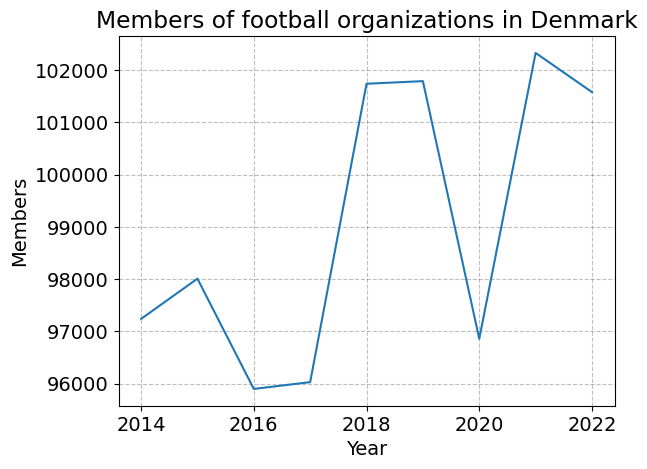

In [33]:
# Plotting the trend
sport_fodbold = sport_long.loc[sport_long['event'] == 'football', :]
ax = sport_fodbold.plot(x='year',y='sport_',legend=False)
ax.set_ylabel('Members')
ax.set_xlabel('Year')
ax.set_title('Members of football organizations in Denmark')
plt.show()

Visually, we can clearly see the upward trend. It's important to acknowledge that the year 2020 stands out significantly in our analysis due to the Covid-19 pandemic. During this time, restrictions in Denmark prohibited group exercise, leading to a decrease in sports memberships. Additionally, professional sporting events were conducted without spectators.

In [34]:
# Creating a dropdown menu, allowing to see the trend for each sport
def plot_e(df, sport):
    I = df['event'] == sport
    ax=df.loc[I,:].plot(x='year', y='sport_', style='-o', legend=False)
    ax.set_ylabel('Members')
    ax.set_xlabel('Year')
    ax.set_title(f'Members of {sport} organizations in Denmark')

In [37]:
widgets.interact(plot_e,
    df = widgets.fixed(sport_long),
    sport = widgets.Dropdown(description='event',
                             options=sport_long.event.unique(),
                             value='football') 
);

interactive(children=(Dropdown(description='event', index=1, options=('basketball', 'football', 'handball', 'i…

### **Fetching data** 

We will utilize DstApi. The dataset includes data on attendance for the four most popular sports (ice hockey, football, handball, and basketball) in Denmark during the period 2007-2023. Our focus will be on the national teams and top leagues, as these typically draw the largest crowds.

In [38]:
# Fetching the data and displaying
ind = DstApi('IDRTIL01')
tabsum = ind.tablesummary(language='en')
display(tabsum)

Table IDRTIL01: Attendances at selected sportsevents by sport, attendances and matches and time
Last update: 2023-10-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,SPORTS,24,SPO005,Ice hockey - International (In Denmark) - men,SPO115,Handball - 1. Division - women,False
1,TILSKUER,3,ENH05,Attendances (numbers),ENH15,Average attendances per match,False
2,Tid,17,2006/2007,2006/2007,2022/2023,2022/2023,True


In [39]:
# Get an overview of relevant variables to be chosen
for variable in tabsum['variable name']:
    print(variable+':')
    display(ind.variable_levels(variable, language='en'))

SPORTS:


,id,text
0,SPO005,Ice hockey - International (In Denmark) - men
1,SPO010,Ice hockey - The Ice Hockey League - men
2,SPO015,Ice hockey - The Ice Hockey League play-offs a...
3,SPO020,Ice hockey - The Ice Hockey League - Season to...
4,SPO025,Football - International (In Denmark) - men
5,SPO030,Football - International (In Denmark) - women
6,SPO035,Football - Superleague - men
7,SPO040,Football - 1. Division - men
8,SPO045,Football - 2. Division - men
9,SPO120,Football - 3. Division - men


TILSKUER:


,id,text
0,ENH05,Attendances (numbers)
1,ENH10,Matches (numbers)
2,ENH15,Average attendances per match


Tid:


,id,text
0,2006/2007,2006/2007
1,2007/2008,2007/2008
2,2008/2009,2008/2009
3,2009/2010,2009/2010
4,2010/2011,2010/2011
5,2011/2012,2011/2012
6,2012/2013,2012/2013
7,2013/2014,2013/2014
8,2014/2015,2014/2015
9,2015/2016,2015/2016


In [57]:
params = ind._define_base_params(language='en')
params

{'table': 'idrtil01',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'SPORTS', 'values': ['*']},
  {'code': 'TILSKUER', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

We now choose the relevant variables from the dataset (recall, the attendance to top league and national team games).

In [58]:
from dataproject import sport_api
sport_api

,event,year,avr_attend
0,icehockey_league,2006/2007,..
1,icehockey_league,2007/2008,..
2,icehockey_league,2008/2009,1437
3,icehockey_league,2009/2010,1362
4,icehockey_league,2011/2012,1489
...,...,...,...
131,football_national,2020/2021,6880
132,basketball_league,2020/2021,99
133,icehockey_national,2021/2022,1500
134,football_national,2021/2022,35314


We encounter a challenge in our dataset: in Denmark, sports seasons begin and end in the summer rather than aligning with the calendar year. To simplify our analysis, we will adopt the following approach:

We will consider the 2006/2007 season as 2007, the 2007/2008 season as 2008, and so forth, with the 2022/2023 season counted as 2023. While this arrangement is not perfect, it is necessary for our analysis.

In [66]:
from dataproject import sport_api_annual
sport_api_annual

,event,year,avr_attend
0,icehockey_league,2006,..
1,icehockey_league,2007,..
2,icehockey_league,2008,1437
3,icehockey_league,2009,1362
4,icehockey_league,2011,1489
...,...,...,...
131,football_national,2020,6880
132,basketball_league,2020,99
133,icehockey_national,2021,1500
134,football_national,2021,35314


In [77]:
# Making the column "avr_attend" numerical
sport_api_annual['avr_attend_numeric'] = pd.to_numeric(sport_api_annual['avr_attend'], errors='coerce')

# Set up an interactive plot
def plot_f(df, sport):
    I = df['event'] == sport
    ax=df.loc[I,:].plot(x='year', y='avr_attend_numeric', style='-o', legend=False)
    ax.set_ylabel('Attendance')
    ax.set_xlabel('Year')
    ax.set_title(f'Attendance at {sport}')

In [78]:
widgets.interact(plot_f,
    df = widgets.fixed(sport_api_annual),
    sport = widgets.Dropdown(description='event',
                             options=sport_api_annual.event.unique(),
                             value='football_national') 
);

interactive(children=(Dropdown(description='event', index=6, options=('icehockey_league', 'football_league', '…

## 4. <a id='toc4_'></a>[Merging datasets](#toc4_)

We aim to prepare our dataset for merging. To achieve this, we consolidate the attendance dataset by creating a single overarching variable for each sport. 
$$
sport_{i} = sport_{i}national + sport_{i}league,
$$
where $i={basketball,football,handball,icehockey}$. Now each sport variable measures the overall attendance in a given year for both national team and league teams. 

In [100]:
# We drop the non-numeric attend-variable
sport_api_annual

,event,year,avr_attend_numeric
0,icehockey_league,2006,NaN
1,icehockey_league,2007,NaN
2,icehockey_league,2008,1437.0
3,icehockey_league,2009,1362.0
4,icehockey_league,2011,1489.0
...,...,...,...
131,football_national,2020,6880.0
132,basketball_league,2020,99.0
133,icehockey_national,2021,1500.0
134,football_national,2021,35314.0


In [98]:
# We group the data by 'year' and 'event'
grouped_data = sport_api_annual.groupby(['year', 'event'])['avr_attend_numeric'].sum().reset_index()

# Select and filter only the 'national' and 'league' observations for each sport, then create a new variable for each
sports = ['icehockey', 'football', 'basketball', 'handball']
for sport in sports:
    filtered_data = grouped_data[grouped_data['event'].str.contains(sport)]
    overall_attend = filtered_data.groupby('year')['avr_attend_numeric'].sum().reset_index()
    overall_attend.rename(columns={'avr_attend_numeric': f'{sport}_overall_attend'}, inplace=True)
    attend_sum = sport_api_annual.merge(overall_attend, on='year', how='left')



KeyError: "['avr_attend'] not found in axis"

In [84]:
# We construct the overall sport variable
sport_api['event'] = sport_api['event'].replace({
    'icehockey_national': 'icehockey',
    'icehockey_league': 'icehockey',
    'football_national': 'football',
    'football_league': 'football',
    'handball_national': 'handball',
    'handball_league': 'handball',
    'basketball_national': 'basketball',
    'basketball_league': 'basketball'
})

# Drop duplicates
sport_api = sport_api.drop(columns=['avr_attend_numeric'])
sport_api = sport_api.drop_duplicates()

KeyError: "['avr_attend_numeric'] not found in axis"

In [90]:
# Makes year the same type (string)
sport_long['year'] = sport_long['year'].astype(str)

# We merge based on 'year' and 'event'
merged = pd.merge(sport_long, sport_api, on=['year','event'], how='inner')
merged

,event,year,,sport_,icehockey_overall_attend,football_overall_attend,basketball_overall_attend,handball_overall_attend
0,basketball,2014,,3170.0,2983.0,26999.0,1579.0,6324.0
1,football,2014,,97240.0,2983.0,26999.0,1579.0,6324.0
2,handball,2014,,22830.0,2983.0,26999.0,1579.0,6324.0
3,icehockey,2014,,1430.0,2983.0,26999.0,1579.0,6324.0
4,basketball,2015,,3120.0,3023.0,32004.0,867.0,10240.0
5,football,2015,,98010.0,3023.0,32004.0,867.0,10240.0
6,handball,2015,,22640.0,3023.0,32004.0,867.0,10240.0
7,icehockey,2015,,1500.0,3023.0,32004.0,867.0,10240.0
8,basketball,2016,,3530.0,2824.0,22962.0,2031.0,6235.0
9,football,2016,,95900.0,2824.0,22962.0,2031.0,6235.0


In [91]:
# A preview of what it would look for 'football'
merged[merged['event'] == 'football']

,event,year,,sport_,icehockey_overall_attend,football_overall_attend,basketball_overall_attend,handball_overall_attend
1,football,2014,,97240.0,2983.0,26999.0,1579.0,6324.0
5,football,2015,,98010.0,3023.0,32004.0,867.0,10240.0
9,football,2016,,95900.0,2824.0,22962.0,2031.0,6235.0
13,football,2017,,96030.0,7735.0,30181.0,3163.0,7358.0
17,football,2018,,101740.0,3501.0,23779.0,2678.0,12518.0
21,football,2019,,101790.0,1575.0,27745.0,3303.0,6523.0
25,football,2020,,96860.0,161.0,8073.0,99.0,525.0
29,football,2021,,102330.0,2925.0,43950.0,1862.0,9542.0
33,football,2022,,101580.0,3568.0,46156.0,1454.0,10117.0


We identify that the majority of the columns are irrelevant. We will now make four datasets that contain the relevant information for each sport

In [92]:
# We make four seperate datasets for each sport
sports = ['football', 'icehockey', 'basketball', 'handball']

for sport in sports:
    globals()[f"{sport}_data"] = merged[merged['event'] == sport]

handball_data = handball_data.drop(['icehockey_overall_attend', 'football_overall_attend', 'basketball_overall_attend'], axis=1)
football_data = football_data.drop(['icehockey_overall_attend', 'handball_overall_attend', 'basketball_overall_attend'], axis=1)
basketball_data = basketball_data.drop(['icehockey_overall_attend', 'football_overall_attend', 'handball_overall_attend'], axis=1)
icehockey_data = icehockey_data.drop(['handball_overall_attend', 'football_overall_attend', 'basketball_overall_attend'], axis=1)

Below we present a preview of each new dataset

In [93]:
handball_data

,event,year,,sport_,handball_overall_attend
2,handball,2014,,22830.0,6324.0
6,handball,2015,,22640.0,10240.0
10,handball,2016,,22320.0,6235.0
14,handball,2017,,22370.0,7358.0
18,handball,2018,,22960.0,12518.0
22,handball,2019,,22750.0,6523.0
26,handball,2020,,22640.0,525.0
30,handball,2021,,21160.0,9542.0
34,handball,2022,,22780.0,10117.0


In [56]:
football_data

,event,year,,sport_,football_overall_attend
1,football,2014,,97240.0,26999.0
5,football,2015,,98010.0,32004.0
9,football,2016,,95900.0,22962.0
13,football,2017,,96030.0,30181.0
17,football,2018,,101740.0,23779.0
21,football,2019,,101790.0,27745.0
25,football,2020,,96860.0,8073.0
29,football,2021,,102330.0,43950.0
33,football,2022,,101580.0,46156.0


In [57]:
basketball_data

,event,year,,sport_,basketball_overall_attend
0,basketball,2014,,3170.0,1579.0
4,basketball,2015,,3120.0,867.0
8,basketball,2016,,3530.0,2031.0
12,basketball,2017,,3440.0,3163.0
16,basketball,2018,,4010.0,2678.0
20,basketball,2019,,4160.0,3303.0
24,basketball,2020,,4320.0,99.0
28,basketball,2021,,4230.0,1862.0
32,basketball,2022,,4590.0,1454.0


In [58]:
icehockey_data

,event,year,,sport_,icehockey_overall_attend
3,icehockey,2014,,1430.0,2983.0
7,icehockey,2015,,1500.0,3023.0
11,icehockey,2016,,1550.0,2824.0
15,icehockey,2017,,1760.0,7735.0
19,icehockey,2018,,1860.0,3501.0
23,icehockey,2019,,2170.0,1575.0
27,icehockey,2020,,2440.0,161.0
31,icehockey,2021,,2500.0,2925.0
35,icehockey,2022,,2380.0,3568.0


## 5. <a id='toc5_'></a>[Analysis](#toc5_)

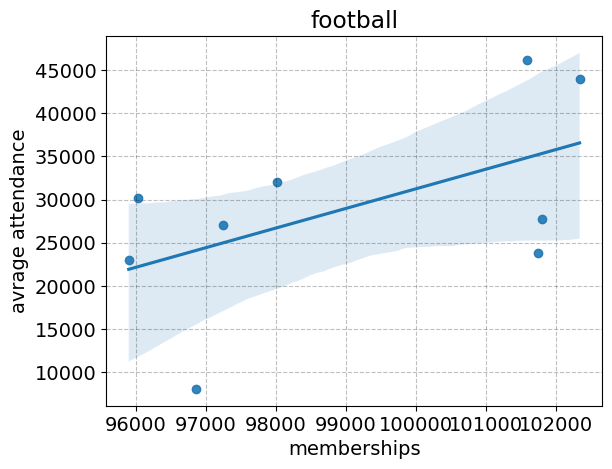

In [102]:
sns.regplot(x=football_data['sport_'], y=football_data['football_overall_attend'], data=football_data, scatter_kws={'alpha':0.9})

plt.xlabel('memberships')
plt.ylabel('avrage attendance')
plt.title('football')

plt.show()

We find a significant positive correlation between high number of spectators and memberships when we look at our football-sample

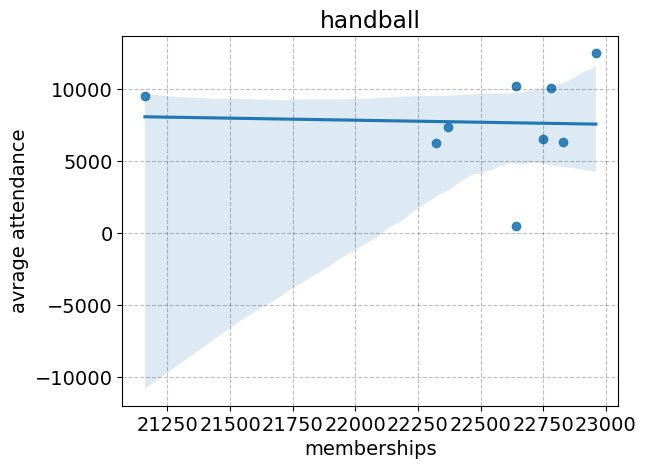

In [103]:
sns.regplot(x=handball_data['sport_'], y=handball_data['handball_overall_attend'], data=handball_data, scatter_kws={'alpha':0.9})

plt.xlabel('memberships')
plt.ylabel('avrage attendance')
plt.title('handball')

plt.show()

However, we find no significant correlation for our handball-sample

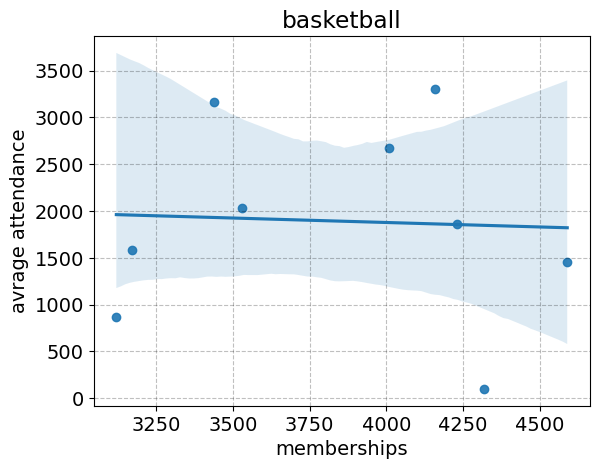

In [104]:
sns.regplot(x=basketball_data['sport_'], y=basketball_data['basketball_overall_attend'], data=basketball_data, scatter_kws={'alpha':0.9})

plt.xlabel('memberships')
plt.ylabel('avrage attendance')
plt.title('basketball')

plt.show()

Again, for basketball we find no significant correlation

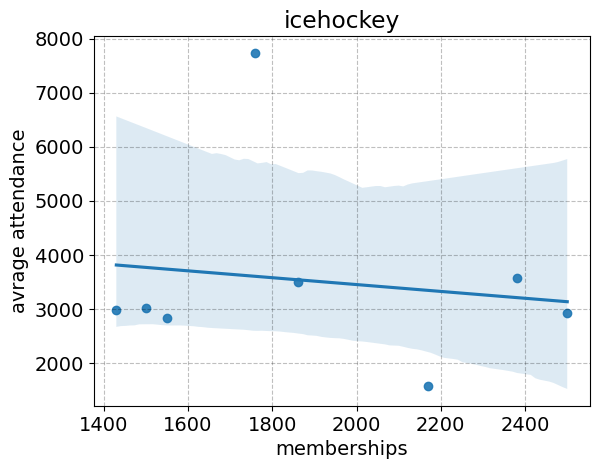

In [107]:
#icehockey_data = icehockey_data[icehockey_data['year'] != '2020']
sns.regplot(x=icehockey_data['sport_'], y=icehockey_data['icehockey_overall_attend'], data=icehockey_data, scatter_kws={'alpha':0.9})

plt.xlabel('memberships')
plt.ylabel('avrage attendance')
plt.title('icehockey')

plt.show()

Finally, for icehockey there seem to be no significant effect

## 6. <a id='toc6_'></a>[Concluding remarks](#toc6_)

First and foremost, we recognize that our data itself had its problems, one counted on annual basis, the other seasonally - moreover one counted the memberships of adults while the other counted attendance of all age groups. This creates some kind of bias in our results.

That being said, our results indicate that there is only a statistically significant correlation between the number of memberships and attendance for football. For the other sports, there was not a significant relationship between these two factors. This suggests that other factors may play a more substantial role in attracting spectators to events within ice hockey, handball, and basketball.

Our findings may be valuable for sports organizations and decision-makers seeking to understand the dynamics between memberships and attendance across different sports. Further research and analysis may be necessary to identify the specific factors influencing attendance within these sports and contribute to the development of strategies to increase spectator turnout.